# Spotify MRS - Data Processing 

## 01.Loading and Combining Data 

In [1]:
# Load the required libraries
import pandas as pd
import numpy as np
import json
import re
import os
import glob
import math
from tqdm import tqdm
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
DATASETS_PATH = 'E:/Internship/Data Analyst-Technocolabs/Data'

FIELDS = ['pid', 'name', 'description', 'modified_at', 'num_artists',
         'num_albums', 'num_tracks', 'num_followers', 'num_edits',
         'duration_ms', 'collaborative']

# Concatenate all json files into a single dataframe and flaten the json object tracks in the original dataset.
for i, dataset in enumerate(glob.glob(DATASETS_PATH+'/*.json')):

    data = json.load(open(dataset))
    
    df_ = pd.json_normalize(data['playlists'], 'tracks', FIELDS, record_prefix= 'track_', errors='ignore')
        
    if i == 0:
        df = df_.copy()
    else:
        df = pd.concat([df, df_], axis=0, ignore_index=True)
        
TRACKS_FIELDS = ['track_pos', 'track_artist_name', 'track_track_uri',
                'track_artist_uri', 'track_track_name', 'track_album_uri',
                'track_duration_ms', 'track_album_name']

df = df.reindex(columns = FIELDS+TRACKS_FIELDS)

df.rename(columns={'duration_ms': 'playlist_duration_ms'}, inplace=True)

for column in df.columns:
    if column in TRACKS_FIELDS:
        df.rename(columns={column : column.split('_', maxsplit=1)[1]}, inplace=True)

df.to_csv(os.path.join(DATASETS_PATH, 'raw_data.csv'), index=False)
df

,pid,name,description,modified_at,num_artists,num_albums,num_tracks,num_followers,num_edits,playlist_duration_ms,collaborative,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name
0,0,Throwbacks,NaN,1493424000,37,47,52,1,6,11532414,false,0,Missy Elliott,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook
1,0,Throwbacks,NaN,1493424000,37,47,52,1,6,11532414,false,1,Britney Spears,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,In The Zone
2,0,Throwbacks,NaN,1493424000,37,47,52,1,6,11532414,false,2,Beyoncé,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,Dangerously In Love (Alben für die Ewigkeit)
3,0,Throwbacks,NaN,1493424000,37,47,52,1,6,11532414,false,3,Justin Timberlake,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,Rock Your Body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,Justified
4,0,Throwbacks,NaN,1493424000,37,47,52,1,6,11532414,false,4,Shaggy,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,Hot Shot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266381,3999,other,NaN,1420848000,17,56,97,1,9,22548683,false,92,Alanis Morissette,spotify:track:7c1iI6dwdCpHGYT8DGEfab,spotify:artist:6ogn9necmbUdCppmNnGOdi,Uninvited,spotify:album:4N7LuZYpstQrtcHIoOKzqg,276200,The Collection
266382,3999,other,NaN,1420848000,17,56,97,1,9,22548683,false,93,Alanis Morissette,spotify:track:4l7YIni9bAiGwWMqK5wvgV,spotify:artist:6ogn9necmbUdCppmNnGOdi,You Learn - 2015 Remastered,spotify:album:5Ap3F8CxjjsQKZGASDcHNA,239640,Jagged Little Pill (Remastered)
266383,3999,other,NaN,1420848000,17,56,97,1,9,22548683,false,94,Alanis Morissette,spotify:track:2LVxvGhl2U5p2ql2ujc6vZ,spotify:artist:6ogn9necmbUdCppmNnGOdi,Hands Clean,spotify:album:0kKfmdca8GY7bDWFWtY801,269400,Under Rug Swept
266384,3999,other,NaN,1420848000,17,56,97,1,9,22548683,false,95,Andrew McMahon in the Wilderness,spotify:track:2Kgjd9G808FhUDRhS2gidG,spotify:artist:716ZwtZBmwROBXcFmCzfdM,Cecilia And The Satellite,spotify:album:1FtH1WWaGL1OvhTMAMw5XI,223879,Andrew McMahon In The Wilderness


## 02. Feature Extraction through Spotipy API

In [3]:
# Create the function to extract the features from track URI
def uri_to_features(uri):

    client_credentials_manager = SpotifyClientCredentials(client_id='fc0dec7eec794907a5a51813eee49655',   
                                                      client_secret='fc8c4306ffdb4e42944bf0706c67a2d0') 
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    
    # Extract audio features
    features = sp.audio_features(uri)[0]
    
    # Extract artists features 
    artist = sp.track(uri)["artists"][0]["id"]
    artist_pop = sp.artist(artist)["popularity"]
    artist_genres = sp.artist(artist)["genres"]
    
    # Extract track features
    track_pop = sp.track(uri)["popularity"]
    
    # Add artists and track features into the audio features
    features["artist_pop"] = artist_pop
    if artist_genres:
        features["genres"] = " ".join([re.sub(' ','_',i) for i in artist_genres])
    else:
        features["genres"] = "unknown"
    features["track_pop"] = track_pop
    
    return features

In [4]:
# Extract only track URI from track_uri column
df["track_uri"] = df["track_uri"].apply(lambda x: re.findall(r'\w+$', x)[0])
df["track_uri"]

0         0UaMYEvWZi0ZqiDOoHU3YI
1         6I9VzXrHxO9rA9A5euc8Ak
2         0WqIKmW4BTrj3eJFmnCKMv
3         1AWQoqb9bSvzTjaLralEkT
4         1lzr43nnXAijIGYnCT8M8H
                   ...          
266381    7c1iI6dwdCpHGYT8DGEfab
266382    4l7YIni9bAiGwWMqK5wvgV
266383    2LVxvGhl2U5p2ql2ujc6vZ
266384    2Kgjd9G808FhUDRhS2gidG
266385    1u0l8zWpQeMYStFkc2mLD7
Name: track_uri, Length: 266386, dtype: object

In [5]:
all_uri = df.track_uri.unique().tolist()
df.track_uri.nunique()

93139

In [6]:
p1, p2, p3, p4, p5 = all_uri[:2000], all_uri[2000:40000], all_uri[40000:60000], all_uri[60000:80000], all_uri[80000:]
api_features = []

In [8]:
# Extract the features using function
for i in tqdm(p1):
    try:
        api_features.append(uri_to_features(i))
    except:
        continue

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [46:42<00:00,  1.40s/it]


In [ ]:
for i in tqdm(p2):
    try:
        api_features.append(uri_to_features(i))
    except:
        continue

In [ ]:
for i in tqdm(p3):
    try:
        api_features.append(uri_to_features(i))
    except:
        continue

In [ ]:
for i in tqdm(p4):
    try:
        api_features.append(uri_to_features(i))
    except:
        continue

In [ ]:
for i in tqdm(p5):
    try:
        api_features.append(uri_to_features(i))
    except:
        continue

I have extracted features using only one list.Because it will take more time to extract features

In [10]:
# Make data frame for features
features_data = pd.DataFrame(api_features)
features_data.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,type,id,uri,track_href,analysis_url,duration_ms,time_signature,artist_pop,genres,track_pop
0,0.904,0.813,4,-7.105,0,0.1210,0.03110,0.006970,0.0471,0.810,...,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4,70,dance_pop hip_hop hip_pop pop_rap r&b rap urba...,67
1,0.774,0.838,5,-3.914,0,0.1140,0.02490,0.025000,0.2420,0.924,...,audio_features,6I9VzXrHxO9rA9A5euc8Ak,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,https://api.spotify.com/v1/tracks/6I9VzXrHxO9r...,https://api.spotify.com/v1/audio-analysis/6I9V...,198800,4,81,dance_pop pop,81
2,0.664,0.758,2,-6.583,0,0.2100,0.00238,0.000000,0.0598,0.701,...,audio_features,0WqIKmW4BTrj3eJFmnCKMv,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,https://api.spotify.com/v1/tracks/0WqIKmW4BTrj...,https://api.spotify.com/v1/audio-analysis/0WqI...,235933,4,88,dance_pop pop r&b,21
3,0.892,0.714,4,-6.055,0,0.1410,0.20100,0.000234,0.0521,0.817,...,audio_features,1AWQoqb9bSvzTjaLralEkT,spotify:track:1AWQoqb9bSvzTjaLralEkT,https://api.spotify.com/v1/tracks/1AWQoqb9bSvz...,https://api.spotify.com/v1/audio-analysis/1AWQ...,267267,4,80,dance_pop pop,76
4,0.853,0.606,0,-4.596,1,0.0713,0.05610,0.000000,0.3130,0.654,...,audio_features,1lzr43nnXAijIGYnCT8M8H,spotify:track:1lzr43nnXAijIGYnCT8M8H,https://api.spotify.com/v1/tracks/1lzr43nnXAij...,https://api.spotify.com/v1/audio-analysis/1lzr...,227600,4,72,dance_pop pop_rap reggae_fusion,0


In [84]:
# Merge the raw data and extracted features
pre_processed_data = pd.merge(df,features_data, left_on = "track_uri", right_on= "id")
print(pre_processed_data .columns)
pre_processed_data .head()

Index(['pid', 'name', 'description', 'modified_at', 'num_artists',
       'num_albums', 'num_tracks', 'num_followers', 'num_edits',
       'playlist_duration_ms', 'collaborative', 'pos', 'artist_name',
       'track_uri', 'artist_uri', 'track_name', 'album_uri', 'duration_ms_x',
       'album_name', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 'analysis_url',
       'duration_ms_y', 'time_signature', 'artist_pop', 'genres', 'track_pop'],
      dtype='object')


,pid,name,description,modified_at,num_artists,num_albums,num_tracks,num_followers,num_edits,playlist_duration_ms,...,type,id,uri,track_href,analysis_url,duration_ms_y,time_signature,artist_pop,genres,track_pop
0,0,Throwbacks,NaN,1493424000,37,47,52,1,6,11532414,...,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4,70,dance_pop hip_hop hip_pop pop_rap r&b rap urba...,67
1,0,Throwbacks,NaN,1493424000,37,47,52,1,6,11532414,...,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4,70,dance_pop hip_hop hip_pop pop_rap r&b rap urba...,67
2,123,w o r k o u t,NaN,1500681600,171,225,245,1,26,55676545,...,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4,70,dance_pop hip_hop hip_pop pop_rap r&b rap urba...,67
3,123,w o r k o u t,NaN,1500681600,171,225,245,1,26,55676545,...,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4,70,dance_pop hip_hop hip_pop pop_rap r&b rap urba...,67
4,218,party playlist,NaN,1504310400,74,93,98,1,4,21299385,...,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4,70,dance_pop hip_hop hip_pop pop_rap r&b rap urba...,67


In [85]:
# Drop duplicate tracks
pre_processed_data['artists_song'] = pre_processed_data.apply(lambda x: x['artist_name']+x['track_name'],axis = 1)
pre_processed_data.drop_duplicates('artists_song')

,pid,name,description,modified_at,num_artists,num_albums,num_tracks,num_followers,num_edits,playlist_duration_ms,...,id,uri,track_href,analysis_url,duration_ms_y,time_signature,artist_pop,genres,track_pop,artists_song
0,0,Throwbacks,NaN,1493424000,37,47,52,1,6,11532414,...,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4,70,dance_pop hip_hop hip_pop pop_rap r&b rap urba...,67,Missy ElliottLose Control (feat. Ciara & Fat M...
42,0,Throwbacks,NaN,1493424000,37,47,52,1,6,11532414,...,6I9VzXrHxO9rA9A5euc8Ak,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,https://api.spotify.com/v1/tracks/6I9VzXrHxO9r...,https://api.spotify.com/v1/audio-analysis/6I9V...,198800,4,81,dance_pop pop,81,Britney SpearsToxic
136,0,Throwbacks,NaN,1493424000,37,47,52,1,6,11532414,...,0WqIKmW4BTrj3eJFmnCKMv,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,https://api.spotify.com/v1/tracks/0WqIKmW4BTrj...,https://api.spotify.com/v1/audio-analysis/0WqI...,235933,4,88,dance_pop pop r&b,21,BeyoncéCrazy In Love
300,0,Throwbacks,NaN,1493424000,37,47,52,1,6,11532414,...,1AWQoqb9bSvzTjaLralEkT,spotify:track:1AWQoqb9bSvzTjaLralEkT,https://api.spotify.com/v1/tracks/1AWQoqb9bSvz...,https://api.spotify.com/v1/audio-analysis/1AWQ...,267267,4,80,dance_pop pop,76,Justin TimberlakeRock Your Body
366,0,Throwbacks,NaN,1493424000,37,47,52,1,6,11532414,...,1lzr43nnXAijIGYnCT8M8H,spotify:track:1lzr43nnXAijIGYnCT8M8H,https://api.spotify.com/v1/tracks/1lzr43nnXAij...,https://api.spotify.com/v1/audio-analysis/1lzr...,227600,4,72,dance_pop pop_rap reggae_fusion,0,ShaggyIt Wasn't Me
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61180,38,tb,NaN,1503446400,42,51,53,1,16,12636678,...,1l6M9DOVGGgamNxexwr7Gx,spotify:track:1l6M9DOVGGgamNxexwr7Gx,https://api.spotify.com/v1/tracks/1l6M9DOVGGga...,https://api.spotify.com/v1/audio-analysis/1l6M...,208493,4,79,dance_pop pop,0,P!nkWho Knew
61190,38,tb,NaN,1503446400,42,51,53,1,16,12636678,...,2aBxt229cbLDOvtL7Xbb9x,spotify:track:2aBxt229cbLDOvtL7Xbb9x,https://api.spotify.com/v1/tracks/2aBxt229cbLD...,https://api.spotify.com/v1/audio-analysis/2aBx...,258133,4,76,dance_pop pop r&b urban_contemporary,72,Mariah CareyAlways Be My Baby
61234,38,tb,NaN,1503446400,42,51,53,1,16,12636678,...,4S5b3wwIXpVNvY2jeIQdKu,spotify:track:4S5b3wwIXpVNvY2jeIQdKu,https://api.spotify.com/v1/tracks/4S5b3wwIXpVN...,https://api.spotify.com/v1/audio-analysis/4S5b...,238920,4,87,barbadian_pop dance_pop pop urban_contemporary,0,RihannaSOS
61272,38,tb,NaN,1503446400,42,51,53,1,16,12636678,...,39afswHs17v53znQm1gDTY,spotify:track:39afswHs17v53znQm1gDTY,https://api.spotify.com/v1/tracks/39afswHs17v5...,https://api.spotify.com/v1/audio-analysis/39af...,229413,4,87,barbadian_pop dance_pop pop urban_contemporary,61,RihannaTake A Bow - Main


In [86]:
# Choose only useful columns
pre_processed_data =pre_processed_data[['pid', 'name', 'modified_at', 'num_artists',
       'num_albums', 'num_tracks', 'num_followers', 'num_edits',
       'playlist_duration_ms', 'collaborative', 'pos', 'artist_name','artist_uri', 'track_name', 'album_uri','duration_ms_x',
       'album_name', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'id', 'track_href', 'analysis_url',
       'duration_ms_y', 'time_signature', 'artist_pop', 'genres', 'track_pop']]

pre_processed_data.head()

,pid,name,modified_at,num_artists,num_albums,num_tracks,num_followers,num_edits,playlist_duration_ms,collaborative,...,tempo,type,id,track_href,analysis_url,duration_ms_y,time_signature,artist_pop,genres,track_pop
0,0,Throwbacks,1493424000,37,47,52,1,6,11532414,false,...,125.461,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4,70,dance_pop hip_hop hip_pop pop_rap r&b rap urba...,67
1,0,Throwbacks,1493424000,37,47,52,1,6,11532414,false,...,125.461,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4,70,dance_pop hip_hop hip_pop pop_rap r&b rap urba...,67
2,123,w o r k o u t,1500681600,171,225,245,1,26,55676545,false,...,125.461,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4,70,dance_pop hip_hop hip_pop pop_rap r&b rap urba...,67
3,123,w o r k o u t,1500681600,171,225,245,1,26,55676545,false,...,125.461,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4,70,dance_pop hip_hop hip_pop pop_rap r&b rap urba...,67
4,218,party playlist,1504310400,74,93,98,1,4,21299385,false,...,125.461,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4,70,dance_pop hip_hop hip_pop pop_rap r&b rap urba...,67


In [87]:
# Pre-process of Genre column
import warnings
warnings.filterwarnings('ignore')
pre_processed_data['genres_list'] = pre_processed_data['genres'].apply(lambda x: x.split(" "))
pre_processed_data['genres_list'].head()

0    [dance_pop, hip_hop, hip_pop, pop_rap, r&b, ra...
1    [dance_pop, hip_hop, hip_pop, pop_rap, r&b, ra...
2    [dance_pop, hip_hop, hip_pop, pop_rap, r&b, ra...
3    [dance_pop, hip_hop, hip_pop, pop_rap, r&b, ra...
4    [dance_pop, hip_hop, hip_pop, pop_rap, r&b, ra...
Name: genres_list, dtype: object

In [88]:
# Make csv file from processed data
pre_processed_data.to_csv(os.path.join(DATASETS_PATH, 'pre_processed_data.csv'), index=False)

## 03.Feature Engineering

### Missing Value Imputation:

In [89]:
import os
os.chdir('E:/Internship/Data Analyst-Technocolabs/Data')

In [67]:
pre_processed_data=pd.read_csv('pre_processed_data.csv')
pre_processed_data.isna().sum()

pid                     0
name                    0
modified_at             0
num_artists             0
num_albums              0
num_tracks              0
num_followers           0
num_edits               0
playlist_duration_ms    0
collaborative           0
pos                     0
artist_name             0
artist_uri              0
track_name              0
album_uri               0
duration_ms_x           0
album_name              0
danceability            0
energy                  0
key                     0
loudness                0
mode                    0
speechiness             0
acousticness            0
instrumentalness        0
liveness                0
valence                 0
tempo                   0
type                    0
id                      0
track_href              0
analysis_url            0
duration_ms_y           0
time_signature          0
artist_pop              0
genres                  0
track_pop               0
genres_list             0
dtype: int64

Data set not include any NA values.So no need to do missing value imputation.

### Outlier Treatment:

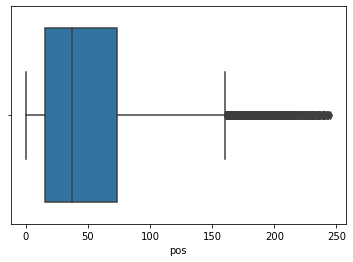

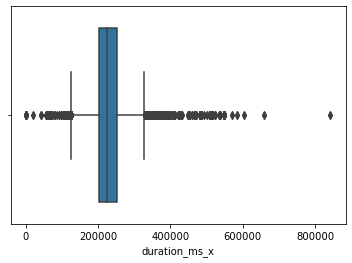

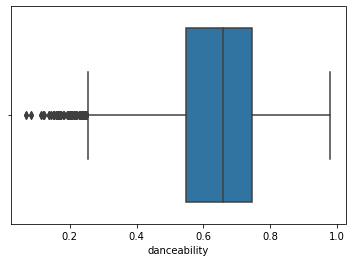

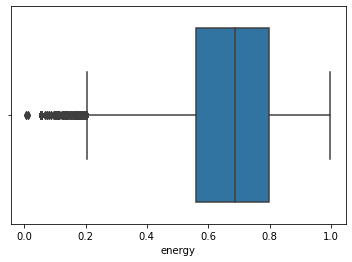

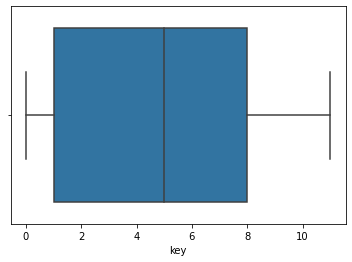

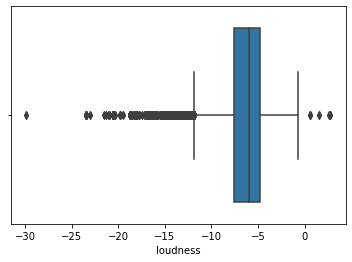

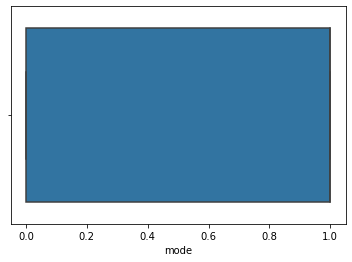

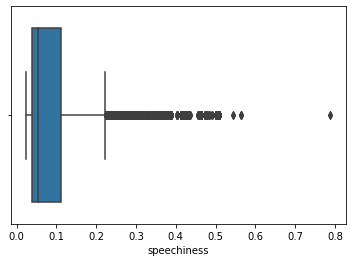

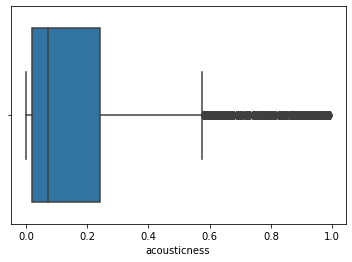

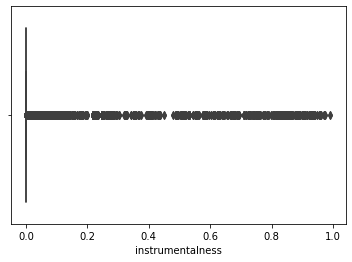

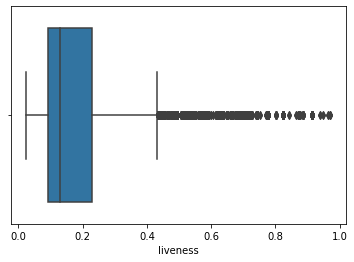

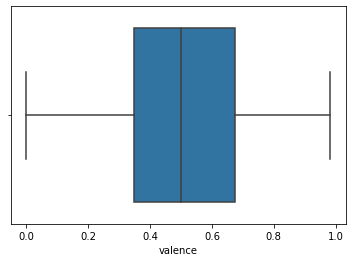

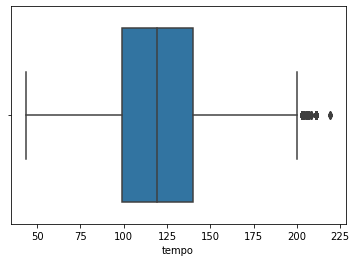

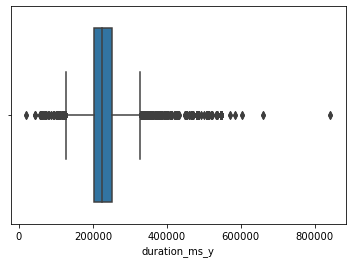

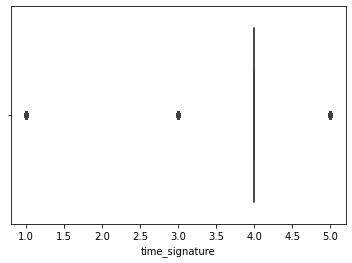

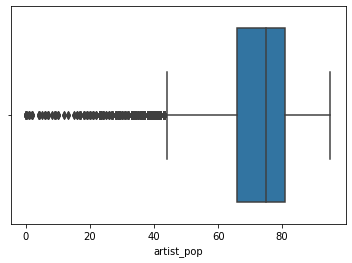

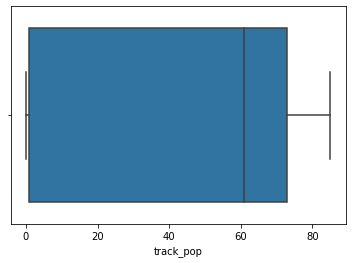

In [90]:
# Check the outliers for continues variables
cont_col=pre_processed_data.select_dtypes(include=['int64','float64'])
for feature in cont_col:
    sn.boxplot(pre_processed_data[feature])
    plt.show()

In [91]:
# Treat the outliers
for feature in cont_col:
    Q1=pre_processed_data[feature].quantile(0.25)
    Q3=pre_processed_data[feature].quantile(0.75)
    IQR=Q3-Q1
    lower=Q1-1.5*IQR
    upper=Q3+1.5*IQR
    pre_processed_data[feature][(pre_processed_data[feature]<lower)]=lower
    pre_processed_data[feature][(pre_processed_data[feature]>upper)]=upper

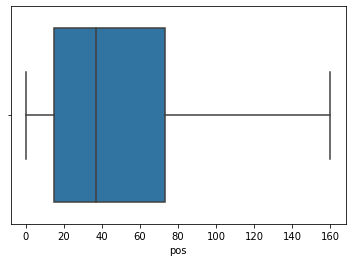

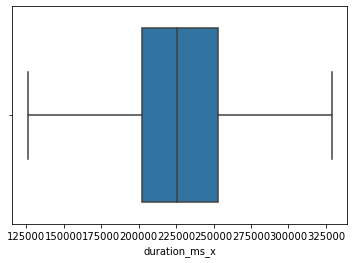

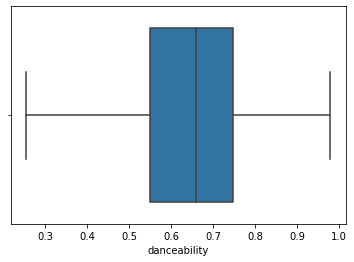

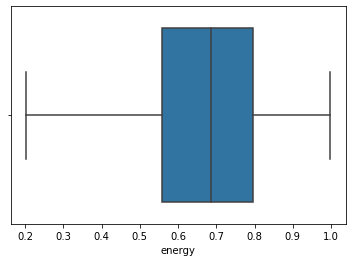

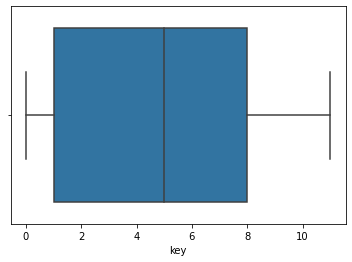

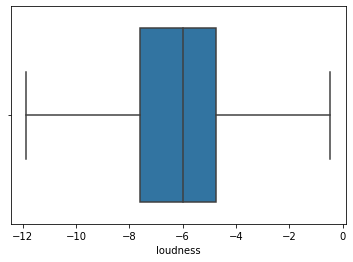

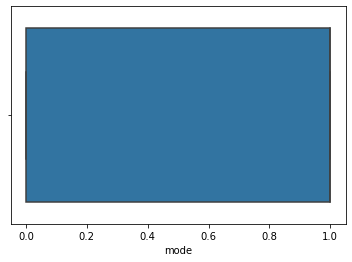

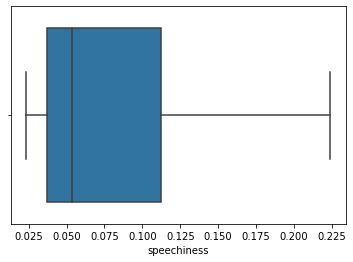

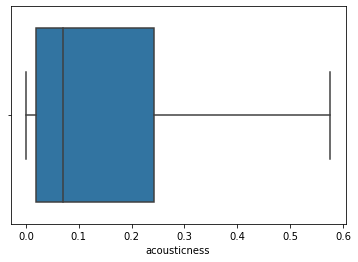

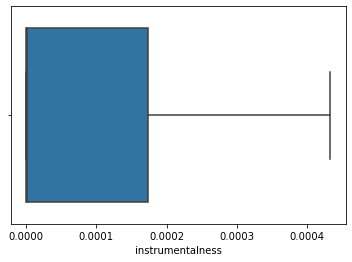

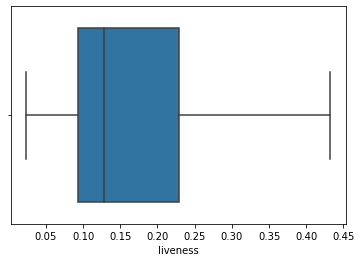

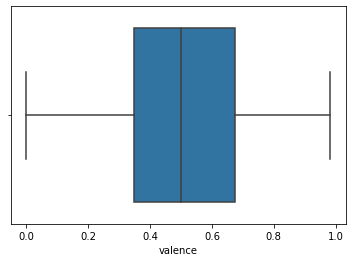

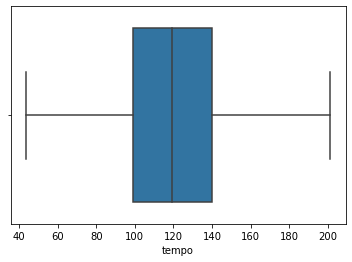

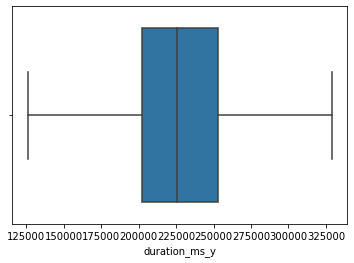

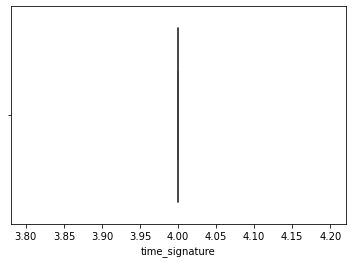

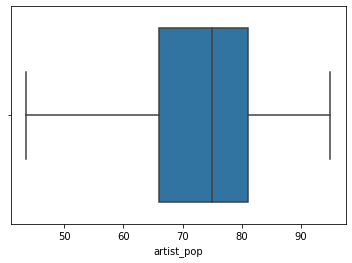

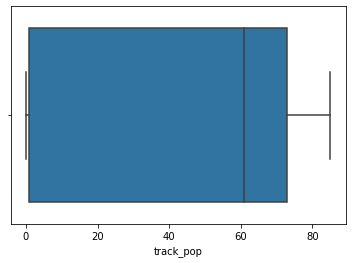

In [92]:
# Check Outliers after treatment
for feature in cont_col:
    sn.boxplot(pre_processed_data[feature])
    plt.show()

###  Handling the Skewness:

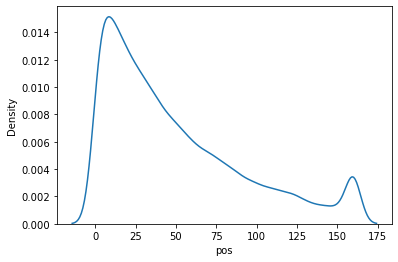

1.019901539232258


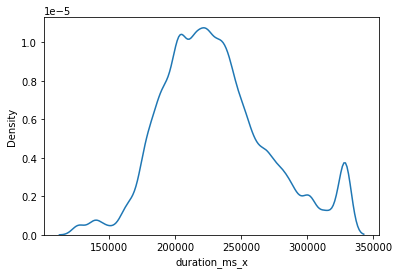

0.48564138873417195


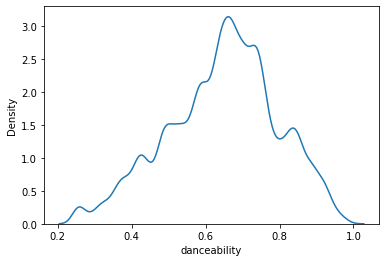

-0.296602871706182


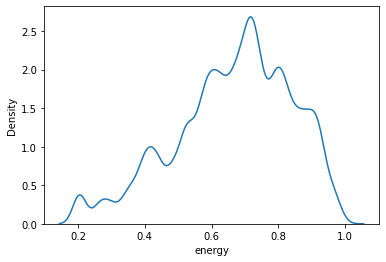

-0.5265992523920188


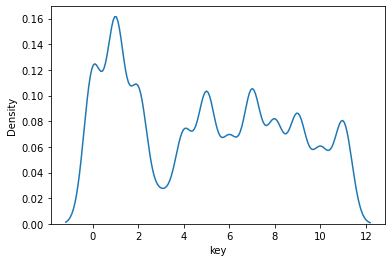

0.14227568958169276


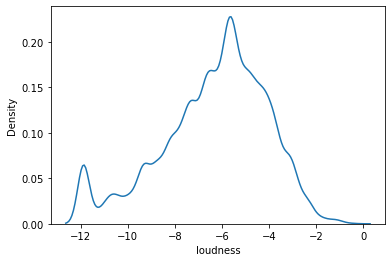

-0.5851481464661404


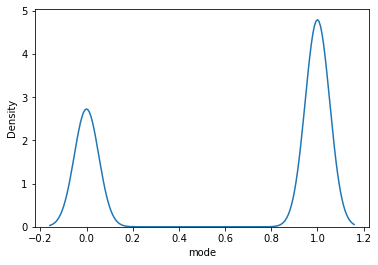

-0.5711424933877101


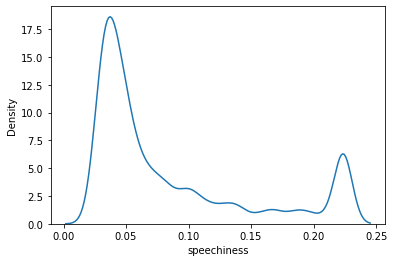

1.19045735742447


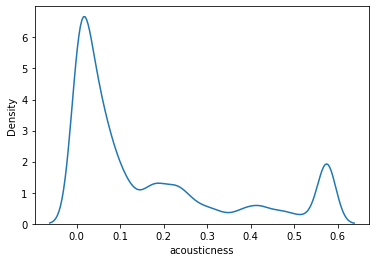

1.1701115584319361


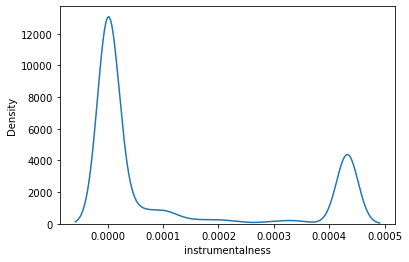

1.1691180889263508


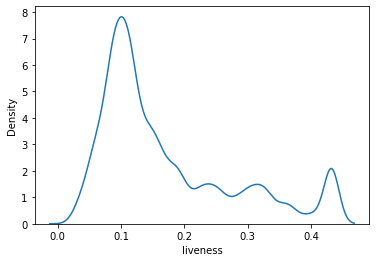

1.102455103682878


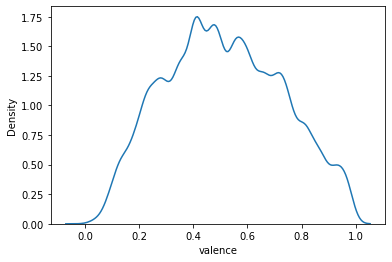

0.11888626936895114


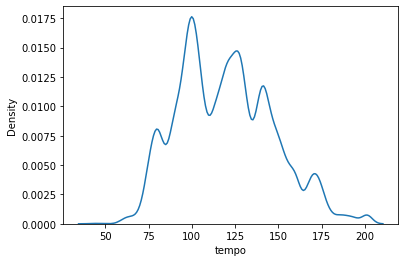

0.39030977338693984


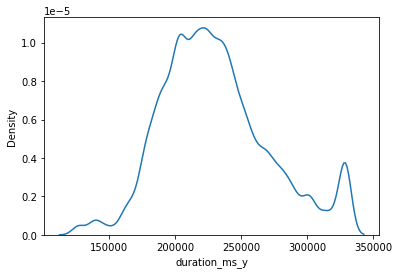

0.4894385081277953


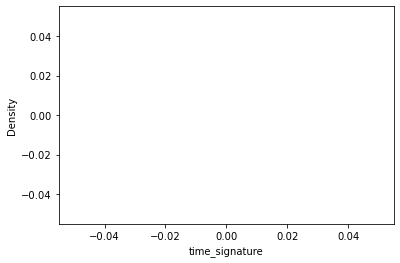

0


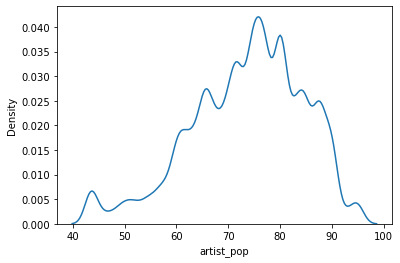

-0.5447745477573673


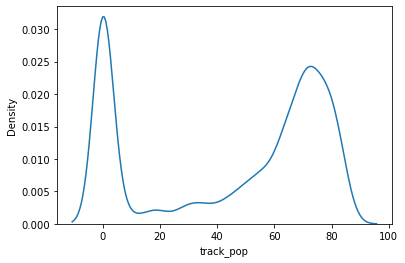

-0.4583770485663374


In [93]:
# Check the skewness for continues variables
for feature in cont_col:
    sn.kdeplot(pre_processed_data[feature])
    plt.show()
    print(pre_processed_data[feature].skew())

As per the outputs,following variables have considerable  skewness:  <br>
  -speechiness<br>
  -acousticness <br>
  -liveness <br>
  -instrumentalness

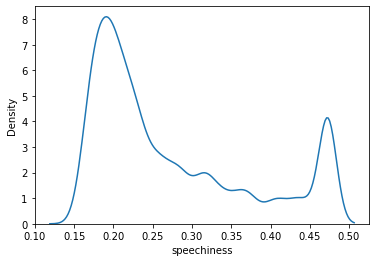

In [94]:
pre_processed_data.speechiness =pre_processed_data.speechiness.apply(lambda x:  np.sqrt(x))
sn.kdeplot(pre_processed_data.speechiness);

In [95]:
pre_processed_data.speechiness.skew()

0.8990333147876872

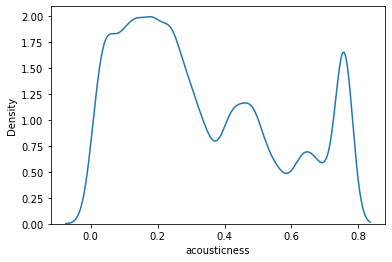

In [96]:
pre_processed_data.acousticness =pre_processed_data.acousticness.apply(lambda x: np.sqrt(x))
sn.kdeplot(pre_processed_data.acousticness);

In [97]:
pre_processed_data.acousticness.skew()

0.5428976768500033

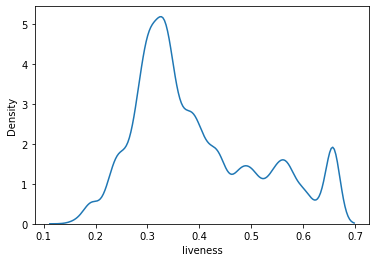

In [98]:
pre_processed_data.liveness =pre_processed_data.liveness.apply(lambda x: np.sqrt(x))
sn.kdeplot(pre_processed_data.liveness);

In [99]:
pre_processed_data.liveness.skew()

0.6851578387787302

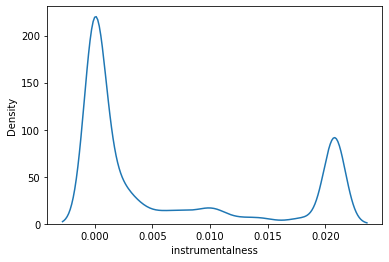

In [100]:
pre_processed_data.instrumentalness =pre_processed_data.instrumentalness.apply(lambda x: np.sqrt(x))
sn.kdeplot(pre_processed_data.instrumentalness);

In [101]:
pre_processed_data.instrumentalness.skew()

0.9163644105499773

### Multicolinearity of features :

In [102]:
vif = pd.DataFrame()
vif["variables"] = cont_col.columns
vif["VIF"] = [variance_inflation_factor(cont_col.values, i) for i in range(cont_col.shape[1])]
vif

,variables,VIF
0,pos,2.210057
1,duration_ms_x,5670.862606
2,danceability,25.244121
3,energy,37.699703
4,key,2.931268
5,loudness,13.070542
6,mode,2.894302
7,speechiness,2.318173
8,acousticness,2.421216
9,instrumentalness,1.146412


As per the results,following varables have highest variance inflation factor:<br>
 -duration_ms_x	<br>
 -danceability <br>
 -energy	<br>
 -loudness	 <br>
 -tempo <br>
 -duration_ms_y <br>
 -time_signature <br>
 -artist_pop	
 So,this varables should be removed before model development.

In [103]:
pre_processed_data=pre_processed_data[['pid', 'name', 'modified_at', 'num_artists',
       'num_albums', 'num_tracks', 'num_followers', 'num_edits',
       'playlist_duration_ms', 'collaborative', 'pos', 'artist_name','artist_uri', 'track_name', 'album_uri',
       'album_name', 'key', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'type', 'id', 'track_href', 'analysis_url', 'genres_list', 'track_pop']]

In [104]:
pre_processed_data.head()

,pid,name,modified_at,num_artists,num_albums,num_tracks,num_followers,num_edits,playlist_duration_ms,collaborative,...,acousticness,instrumentalness,liveness,valence,type,id,track_href,analysis_url,genres_list,track_pop
0,0,Throwbacks,1493424000,37,47,52,1,6,11532414,false,...,0.176352,0.020797,0.217025,0.81,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,"[dance_pop, hip_hop, hip_pop, pop_rap, r&b, ra...",67
1,0,Throwbacks,1493424000,37,47,52,1,6,11532414,false,...,0.176352,0.020797,0.217025,0.81,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,"[dance_pop, hip_hop, hip_pop, pop_rap, r&b, ra...",67
2,123,w o r k o u t,1500681600,171,225,245,1,26,55676545,false,...,0.176352,0.020797,0.217025,0.81,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,"[dance_pop, hip_hop, hip_pop, pop_rap, r&b, ra...",67
3,123,w o r k o u t,1500681600,171,225,245,1,26,55676545,false,...,0.176352,0.020797,0.217025,0.81,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,"[dance_pop, hip_hop, hip_pop, pop_rap, r&b, ra...",67
4,218,party playlist,1504310400,74,93,98,1,4,21299385,false,...,0.176352,0.020797,0.217025,0.81,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,"[dance_pop, hip_hop, hip_pop, pop_rap, r&b, ra...",67


### TF-IDF Vectorization :

In [105]:
# Tfidf for genre list column
tfidf = TfidfVectorizer()
tfidf_matrix =  tfidf.fit_transform(pre_processed_data['genres_list'].apply(lambda x: " ".join(x)))
genre_tfidf_data = pd.DataFrame(tfidf_matrix.toarray())
genre_tfidf_data.columns = ['genre' + "|" + i for i in tfidf.get_feature_names()]
# drop unknown genre
genre_tfidf_data.drop(columns='genre|unknown') 
genre_tfidf_data.reset_index(drop = True, inplace=True)

### Sentiment Analysis :

In [106]:
# Build the function to analyse the subjectivity and polarity

def subjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def polarity(text):
  return TextBlob(text).sentiment.polarity

def sp_analysis(score, task="polarity"):
  if task == "subjectivity":
    if score < 1/3:
      return "low"
    elif score > 1/3:
      return "high"
    else:
      return "medium"
  else:
    if score < 0:
      return 'Negative'
    elif score == 0:
      return 'Neutral'
    else:
      return 'Positive'

def sentiment_analysis(df, text_col):
  df['subjectivity'] = df[text_col].apply(subjectivity).apply(lambda x: sp_analysis(x,"subjectivity"))
  df['polarity'] = df[text_col].apply(polarity).apply(sp_analysis)
  return df

In [107]:
# Sentiment analysis
sentiment_data = sentiment_analysis(pre_processed_data, "track_name")

### One-Hot Encoding :

In [108]:
# Build the function for one-Hot encoding
def ohe(df, column, new_name): 
    ohe_df = pd.get_dummies(df[column])
    feature_names = ohe_df.columns
    ohe_df.columns = [new_name + "|" + str(i) for i in feature_names]
    ohe_df.reset_index(drop = True, inplace = True)    
    return ohe_df

In [109]:
# One-hot Encoding for subjectivity column
subject_ohe_data = ohe(sentiment_data, 'subjectivity','subject') 
# One-hot Encoding for polarity column
polar_ohe_data = ohe(sentiment_data, 'polarity','polar') 
# One-hot Encoding for mode column
mode_ohe_data = ohe(sentiment_data, 'mode','mode')

### Normalization :

In [110]:
# Scale track popularity colum
at_pop = sentiment_data[["track_pop"]].reset_index(drop = True)
scaler = MinMaxScaler()
pop_scaled_data = pd.DataFrame(scaler.fit_transform(at_pop), columns = at_pop.columns)
# Scale audio columns
float_cols = sentiment_data.dtypes[sentiment_data.dtypes == 'float64'].index.values
floats = sentiment_data[float_cols].reset_index(drop = True)
scaler = MinMaxScaler()
floats_scaled_data = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns)

## 04.Final Features

In [125]:
# Combine the all data frames
final_features = pd.concat([pre_processed_data.id,genre_tfidf_data, floats_scaled_data, pop_scaled_data,
                            subject_ohe_data, polar_ohe_data, mode_ohe_data], axis = 1)
final_features.head()

,id,genre|_hip_hop,genre|a_cappella,genre|abstract_beats,genre|abstract_hip_hop,genre|acoustic_blues,genre|acoustic_pop,genre|acoustic_rock,genre|adult_standards,genre|aesthetic_rap,...,valence,track_pop,subject|high,subject|low,subject|medium,polar|Negative,polar|Neutral,polar|Positive,mode|0,mode|1
0,0UaMYEvWZi0ZqiDOoHU3YI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.824847,0.788235,0,1,0,0,1,0,1,0
1,0UaMYEvWZi0ZqiDOoHU3YI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.824847,0.788235,0,1,0,0,1,0,1,0
2,0UaMYEvWZi0ZqiDOoHU3YI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.824847,0.788235,0,1,0,0,1,0,1,0
3,0UaMYEvWZi0ZqiDOoHU3YI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.824847,0.788235,0,1,0,0,1,0,1,0
4,0UaMYEvWZi0ZqiDOoHU3YI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.824847,0.788235,0,1,0,0,1,0,1,0


In [126]:
# Convert the final features data frame into csv file
final_features.to_csv("final_features.csv", index = False)